In [71]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import CSVLogger
import os
import matplotlib.pyplot as plt
from numpy import savetxt
import pandas as pd
import shutil

In [72]:
test_data_dir = 'data/sc5-test'
train_data_dir = 'data/sc5'

def move(validation_data_dir):
    '''
    only do this once
    '''
    gt = pd.read_csv(os.path.join(validation_data_dir, 'ground_truth.txt'),sep = ';', header = None)

    for root, dirs, files in os.walk(validation_data_dir):
        for file in files:
            if file.endswith('jpg'):
                img_class = gt.loc[gt[0]==file].iloc[0][1]
                x = img_class.split(" ")
                x = [i.replace(":","") for i in x]
                img_class = "".join(x)

                dir_ = os.path.join(root, img_class)
                if not os.path.exists(dir_):
                    os.mkdir(dir_)
                old, new = os.path.join(root, file), os.path.join(dir_, file)
                shutil.move(old, new)
    print("done")
    
#move(test_data_dir)

In [75]:
test = sorted([i for i in os.listdir(test_data_dir) if os.path.isdir(os.path.join(os.getcwd(),os.path.join(test_data_dir,i)))])
train = sorted([i for i in os.listdir(train_data_dir) if os.path.isdir(os.path.join(os.getcwd(),os.path.join(train_data_dir,i)))])

to_keep = set(test).intersection(set(train)) # number of classes to keep
len(to_keep)

0

In [76]:
def select_classes():
    for root, dirs, files in os.walk(test_data_dir):
        c_name = root.split("/")[-1]
        if c_name in to_keep and len(os.listdir(root)) < 50:
            to_keep.remove(c_name)
            print("deleted {} with {} samples".format(c_name, len(os.listdir(root))))

In [77]:
to_keep

set()

In [78]:
def move2(test_data_dir, train_data_dir, to_keep):
    '''
    gets rid of classes that dont appear on both sets
    '''
    for i in os.listdir(test_data_dir):
        if i not in to_keep:
            q=os.path.join(test_data_dir, i)
            if os.path.isdir(q):
                shutil.rmtree(q)
    print("------")
    for i in os.listdir(train_data_dir):
        if i not in to_keep:
            q=os.path.join(train_data_dir, i)
            if os.path.isdir(q):
                shutil.rmtree(q)
#move2(test_data_dir, train_data_dir, to_keep)

In [16]:
folder_name = train_data_dir
categories = [i for i in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir,i))]

if not os.path.isdir(train_data_dir+"/"+"train"):
    os.makedirs(train_data_dir+"/"+"train")
if not os.path.isdir(train_data_dir+"/"+"validation"):
    os.makedirs(train_data_dir+"/"+"validation")

In [17]:
#lets read the images from the folder
image_name = {}
count = 0 
for name in categories:
    name_= []
    if not name.endswith('txt'):
        image_name_ =  os.listdir(folder_name+"/"+name)
        myfolder=""
        for each in image_name_:
            file_split  = each.split(".")
            file_name =  name+"."+str(count)+"."+file_split[1]
            if not os.path.isdir(folder_name+"/train/"+name):
                myfolder  = folder_name+"/train/"+name
                os.makedirs(myfolder)
            
            shutil.move(folder_name+'/'+name+"/"+each,myfolder+"/"+file_name)
            
            name_.append(myfolder+"/"+file_name)
            count+=1
        
        shutil.rmtree(folder_name+'/'+name)
        
        image_name[name] = name_

In [18]:
for name in os.listdir(folder_name+"/train/"):
    if not os.path.isdir(folder_name+"/validation/"+name):
        myfolder  = folder_name+"/validation/"+name
        os.makedirs(myfolder)

In [21]:
val_folder = os.listdir(folder_name+"/train/")
for v in val_folder:
    myfiles = os.listdir(folder_name+"/train/"+v)
    if len(myfiles)>50:
        some_files = myfiles[:50]
        for each in some_files:
            shutil.move(folder_name+"/train/"+v+"/"+each,folder_name+"/validation/"+v+"/"+each)

In [22]:
train_data_dir = 'data/sc5/train'
validation_data_dir = 'data/sc5/validation'

#number of training images
nb_train_samples = 0
for root, dirs, files in os.walk(train_data_dir):
    nb_train_samples += len([i for i in files if i.endswith('.jpg')])

#number of images used for testing (validation)
nb_validation_samples = 0
for root, dirs, files in os.walk(validation_data_dir):
    nb_validation_samples += len([i for i in files if i.endswith('.jpg')])
print("Traning: {}\nTesting: {}".format(nb_train_samples, nb_validation_samples))

Traning: 2510
Testing: 1300


In [23]:
# CNN MODEL
def VGCC18(n_classes, img_width, img_height): #n--numebr of classes
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)
    print(input_shape)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(n_classes)) #18 classes
    model.add(Activation('softmax'))
    return model


In [24]:
#size of our generated images
img_width, img_height = 200, 200

model = VGCC18(n_classes = len(to_keep),
              img_width = img_width,
              img_height = img_height)

model.summary()

(200, 200, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 97, 97, 64)        0      

In [25]:
#tracking our model
csv_logger = CSVLogger('training.log')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])


epochs = 10
batch_size = 32

##Data augmentation##
#for training
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    zoom_range=0.2,
    horizontal_flip=True)

#for testing
test_datagen = ImageDataGenerator(rescale=1. / 255)

#further augmentation of our data
#training
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode = 'categorical')
#testing
validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode = 'categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=800 // batch_size,
    callbacks=[csv_logger], #logging our progress
    verbose = 1)

Found 2510 images belonging to 18 classes.
Found 1300 images belonging to 18 classes.
Epoch 1/10
62/62 [==============================] - 165s 3s/step - loss: 1.7636 - acc: 0.4944 - val_loss: 2.8371 - val_acc: 0.2450
Epoch 2/10
62/62 [==============================] - 179s 3s/step - loss: 1.4645 - acc: 0.5994 - val_loss: 2.5830 - val_acc: 0.3513
Epoch 3/10
62/62 [==============================] - 185s 3s/step - loss: 1.3695 - acc: 0.6302 - val_loss: 2.4946 - val_acc: 0.3200
Epoch 4/10
62/62 [==============================] - 186s 3s/step - loss: 1.1660 - acc: 0.6946 - val_loss: 2.4724 - val_acc: 0.3613
Epoch 5/10
62/62 [==============================] - 177s 3s/step - loss: 1.1094 - acc: 0.7188 - val_loss: 2.0369 - val_acc: 0.4175
Epoch 6/10
62/62 [==============================] - 186s 3s/step - loss: 0.9967 - acc: 0.7514 - val_loss: 2.1381 - val_acc: 0.4062
Epoch 7/10
62/62 [==============================] - 172s 3s/step - loss: 1.0282 - acc: 0.7480 - val_loss: 1.9151 - val_acc: 0.43

In [26]:
try:
	scores = model.evaluate_generator(validation_generator, nb_validation_samples // batch_size, pickle_safe = False)
	predict = model.predict_generator(validation_generator, nb_validation_samples // batch_size, verbose=1)
	savetxt('scores.txt', scores)
	savetxt('predictions.txt', predict)
except BaseException as error:
    print('An exception occurred: {}'.format(error))

model.save_weights('my_model_weights_2.h5') #saving weights for further analysis
model.save('my_model_2.h5')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., 40, use_multiprocessing=False)`
  


40/40 [==============================] - 31s 768ms/step


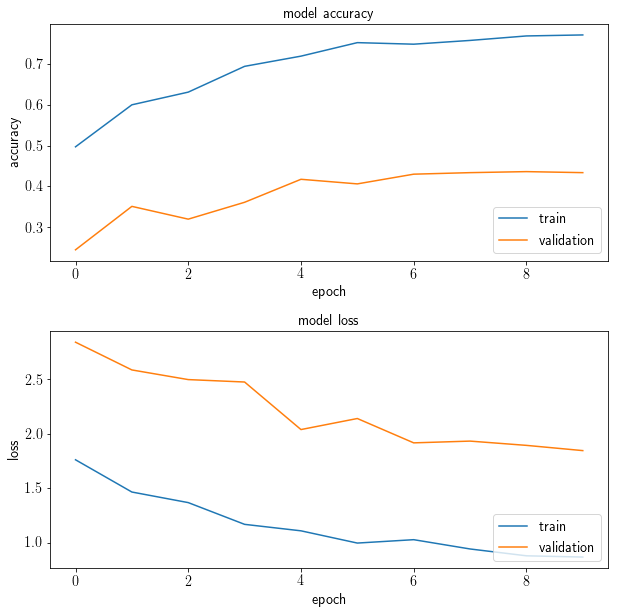

In [84]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True
plt.rcParams.update({'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'})


history = pd.read_csv('training.log')
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
plt.subplot(211)
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.show()
plt.subplot(212)
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [28]:
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 1252 images belonging to 18 classes.


In [29]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

1252/1252 [==============================] - 26s 21ms/step


In [31]:
import numpy as np

In [32]:
predicted_class_indices=np.argmax(pred,axis=1)

In [33]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [34]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [41]:
history

,epoch,acc,loss,val_acc,val_loss
0,0,0.496948,1.760077,0.24500,2.837141
1,1,0.599695,1.464714,0.35125,2.583037
2,2,0.630722,1.367841,0.32000,2.494601
3,3,0.693795,1.168632,0.36125,2.472368
4,4,0.718750,1.109353,0.41750,2.036891
5,5,0.751780,0.997216,0.40625,2.138067
6,6,0.747984,1.028195,0.43000,1.915085
7,7,0.757187,0.943153,0.43375,1.931159
8,8,0.768145,0.880529,0.43625,1.892074
9,9,0.770600,0.869058,0.43375,1.844103


In [59]:
r = 0
for i in range(len(filenames)):
    if filenames[i].split("/")[0] == predictions[i]:
        r+=1
accuracy = r/len(filenames) * 100
accuracy

68.9297124600639

In [80]:
model

AttributeError: 'Sequential' object has no attribute 'load'

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 240, 800

top_model_weights_path = 'bottleneck_fc_model.h5'

train_data_dir = 'data/sc5'
validation_data_dir = 'data/sc5-test'
#number of training images
nb_train_samples = 0
for root, dirs, files in os.walk(train_data_dir):
    nb_train_samples += len([i for i in files if i.endswith('.jpg')])

#number of images used for testing (validation)
nb_validation_samples = 0
for root, dirs, files in os.walk(validation_data_dir):
    nb_validation_samples += len([i for i in files if i.endswith('.jpg')])
print("Traning: {}\nTesting: {}".format(nb_train_samples, nb_validation_samples))

epochs = 50
batch_size = 16

In [ ]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'w'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'w'),
            bottleneck_features_validation)


def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy'))
    train_labels = np.array(
        [0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))

    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = np.array(
        [0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


save_bottlebeck_features()
#train_top_model()

In [ ]:
import numpy as np

In [ ]:
plt.imread('data/sc5/Gondola/20130410_122235_88375.jpg').shape

In [ ]:
ee=0
for root, dirs, files in os.walk(train_data_dir):
        if len(os.listdir(root))>200: ee+=1
print(ee)

In [ ]:
len(os.listdir(root))

In [ ]:
train_data_dir

In [82]:
pd.save_csv

AttributeError: module 'pandas' has no attribute 'save_csv'